In [873]:
#%%
# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'

# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np
#from collections import Counter
from boolma import BM

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

def dist_boxplot(x, **kwargs):
    ax = sns.distplot(x, hist_kws=dict(alpha=0.2))
    ax2 = ax.twinx()
    sns.boxplot(x=x, ax=ax2)
    ax2.set(ylim=(-5, 5))


#%% DATA
## I/O
import zipfile
import requests
import pickle

# Normalization function
def norm(vec):
    return (vec-vec.mean())/vec.std()

# READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
onet = {}
def from_onet(qualities):
        if qualities in onet:
                return onet[qualities]
        pickle_exists = os.path.isfile('./data/pickle/'+qualities+'.pkl')
        if pickle_exists:
                onet[qualities] = pd.read_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]
        else: 
                onet[qualities]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+qualities+'.xlsx'))
                onet[qualities].to_pickle('./data/pickle/'+qualities+'.pkl')
                return onet[qualities]


# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socc):
    code = str(socc).replace('-','')
    return code[:6]

# CENSUS DATA: select workers in ages 40 - 65 and discard the occupations with large standard deviations.
all_workers = pd.read_pickle('data/pickle/pums_California.pkl')
workers = BM(all_workers).select(
            'AGEP','gt',40).select(
            'AGEP','lt',65).df
workers['log FTE'] = workers['FTE wage'].apply(np.log)
foo = workers.groupby('SOCP') 
all_occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
all_occupations['count'] = foo.count()['AGEP']
all_occupations['std log FTE'] = foo.std()['log FTE']
all_occupations['SOCP'] = all_occupations.index
all_occupations['SOCP_shave'] = all_occupations['SOCP'].apply(soc)
all_occupations['Occupation'] = all_occupations['SOCP']
occupations = all_occupations[all_occupations['std log FTE']<0.50]

#%%  CREATE X:features from O*NET; and y: mean wages from census/pums

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    foo = matrix(features)
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


# SELECT FEATURE SETS FROM O*NET, FIT FOR O*NET FTE WAGES 

# Prepare feature sets.
def prepare(df):
    # For Abilities, Knowledge, Skills
    if 'LV' in set(df['Scale ID']):
        sid = 'LV'
    # For Interests
    elif 'OI' in set(df['Scale ID']):
        sid = 'OI'
    df = df[df['Scale ID'] == sid]

    return df[['O*NET-SOC Code','Element Name','Data Value']]
        

dab = prepare(from_onet('Abilities'))
dkn = prepare(from_onet('Knowledge'))
dsk = prepare(from_onet('Skills'))
din = prepare(from_onet('Interests'))

In [65]:
featuresets = [dab,dkn,dsk,din]
featurenames = ['Abilities','Knowledge','Skills','Interests']
methodnames = ['Ridge','Random Forest','Boost']

In [123]:
#%% MODEL & FIT

reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)


fit = {}
feat = {}
result = {}
n=4
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(rf,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].feature_importances_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].feature_importances_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity

class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.pw = pd.DataFrame(self.w,index=X.index)
        self.pwn = nrmcol(self.pw.T).T
        self.h = self.model.components_
        self.ph = pd.DataFrame(self.h,columns=X.columns)
        self.phn = nrmcol(self.ph.T).T


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.pvt = pd.DataFrame(self.vt,columns=X.columns)
        self.pu = pd.DataFrame(self.u,columns=X.index)

        
def nrmcol(df):
    return df / np.sqrt(np.diagonal(df.T @ df))





#%%

In [2]:
result[1]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([0.14853907, 0.11878705, 0.11978221, 0.12582111]),
 'score_time': array([0.00725102, 0.00283718, 0.00691986, 0.00508094]),
 'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
             oob_score=False, random_state=0, verbose=0, warm_start=False),
  RandomForestRegressor(bootstrap=True, criterion='ms

In [119]:
reg_ridge = linear_model.Ridge(alpha=.5)
rf = RandomForestRegressor(n_estimators=40,
                           max_features='auto',
                           random_state=0)
boo = GradientBoostingRegressor(n_estimators=100, learning_rate=0.08, max_depth=1)



fit = {}
feat = {}
result = {}
Xy_test= {}
n=3
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=37)
    Xy_test[ft]=(X_test,y_test)
    res = cross_validate(reg_ridge,X_train, y_train, cv=n, return_estimator=True)
    res_rf = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
    res_boo = cross_validate(boo,X_train, y_train, cv=n, return_estimator=True)
    result[ft] = (res,res_rf,boo)
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)




In [120]:
def resplot(f,e):
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][0].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][1].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][2].predict(Xy_test[f][0]))
    #plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][3].predict(Xy_test[f][0]))
    plt.ylim(-3,3)
    plt.title(featurenames[f]+' - '+ methodnames[e])

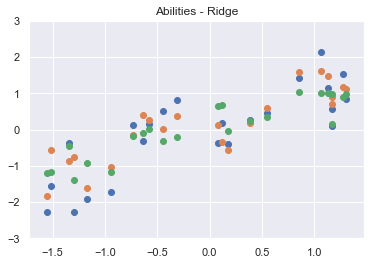

In [121]:
resplot(0,0)

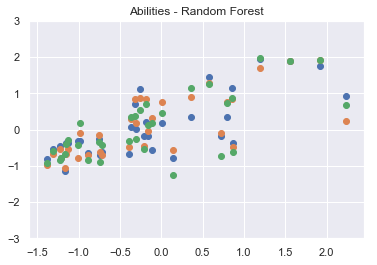

In [108]:
resplot(0,1)

In [109]:
feat[0].sort_values('mean',ascending=False)

,0,1,2,mean,std
Written Comprehension,0.740948,0.229892,0.615675,0.528838,0.217486
Glare Sensitivity,0.028175,0.476317,0.537384,0.347292,0.227023
Depth Perception,0.465026,0.228793,0.252754,0.315525,0.106165
Stamina,0.265512,0.490935,0.188371,0.314939,0.128371
Manual Dexterity,0.401056,0.146872,0.285970,0.277966,0.103925
Information Ordering,0.061958,0.070685,0.450452,0.194365,0.181116
Gross Body Equilibrium,0.150535,0.259063,0.154889,0.188162,0.050166
Problem Sensitivity,-0.062606,0.215877,0.330164,0.161145,0.164952
Mathematical Reasoning,0.173826,0.091610,0.187600,0.151012,0.042379
Explosive Strength,0.066548,0.170229,0.164867,0.133881,0.047662


In [75]:
result[0]

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


({'fit_time': array([0.00152993, 0.00153017, 0.00150394]),
  'score_time': array([0.00073695, 0.00069904, 0.00073409]),
  'estimator': (Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001),
   Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001),
   Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)),
  'test_score': array([0.60047947, 0.43499273, 0.46112681]),
  'train_score': array([0.85078108, 0.86309015, 0.87693482])},
 {'fit_time': array([0.05339003, 0.05450392, 0.05184007]),
  'score_time': array([0.00285602, 0.0026648 , 0.0025878 ]),
  'estimator': (RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
  

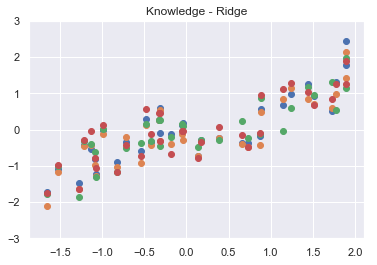

In [89]:
resplot(1,0)

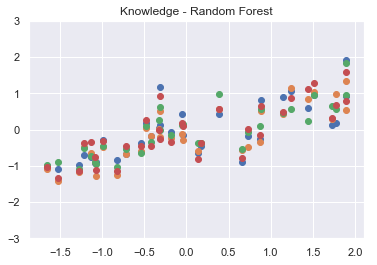

In [90]:
resplot(1,1)

In [69]:
result[1][2]['estimator']

IndexError: tuple index out of range

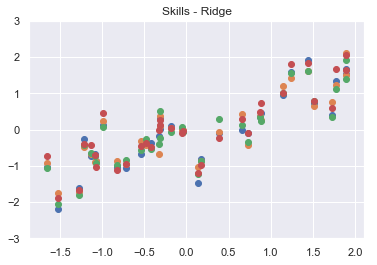

In [91]:
resplot(2,0)

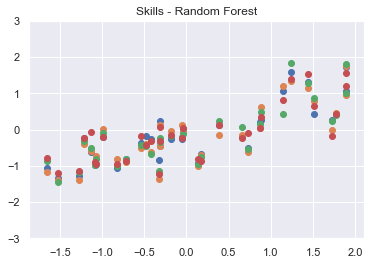

In [92]:
resplot(2,1)

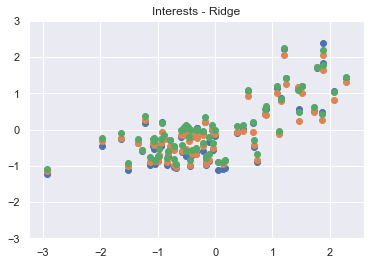

In [61]:
resplot(3,0)

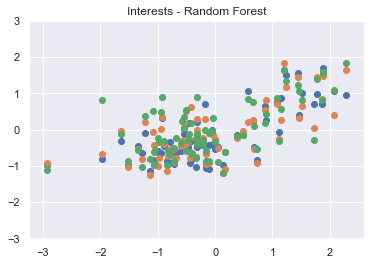

In [62]:
resplot(3,1)

In [80]:
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(rf,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].feature_importances_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].feature_importances_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


In [81]:
feat[0].sort_values('mean',ascending = False).head()

,0,1,2,mean,std
Information Ordering,0.057330,0.054371,0.462524,0.191408,0.191712
Deductive Reasoning,0.101301,0.261099,0.140320,0.167573,0.068024
Written Comprehension,0.070526,0.206204,0.021251,0.099327,0.078205
Inductive Reasoning,0.114409,0.086960,0.051871,0.084413,0.025595
Oral Comprehension,0.072506,0.019618,0.010725,0.034283,0.027271


In [82]:
for ft in range(len(featuresets)):
    X, y = xy(featuresets[ft],occupations)
    res = cross_validate(reg_ridge,X, y, cv=n, return_estimator=True)
    result[ft] = res
    feat[ft] = pd.DataFrame(res['estimator'][0].coef_,index=X.columns)
    for i in range(n):
        feat[ft][i] = pd.DataFrame(res['estimator'][i].coef_,index=X.columns)
    feat[ft]['mean'] = feat[ft].mean(axis=1)
    feat[ft]['std'] = feat[ft].std(axis=1)


In [83]:
feat[0].sort_values('mean',ascending = False).head()

,0,1,2,mean,std
Written Comprehension,0.486088,0.208410,0.499608,0.398035,0.134199
Depth Perception,0.320566,0.338598,0.309226,0.322797,0.012094
Control Precision,0.162397,0.168638,0.389860,0.240298,0.105787
Glare Sensitivity,0.459667,0.247599,-0.020297,0.228989,0.196386
Gross Body Equilibrium,0.387483,0.209516,0.049998,0.215666,0.137847


In [84]:
feat[1].sort_values('mean',ascending = False).head()

,0,1,2,mean,std
Physics,0.206371,0.335668,0.310081,0.284040,0.055905
Law and Government,0.102732,0.354099,0.273637,0.243490,0.104811
Computers and Electronics,0.122966,0.203627,0.370128,0.232240,0.102912
English Language,0.097209,0.281729,0.146568,0.175169,0.077998
Sociology and Anthropology,-0.074259,0.127507,0.453350,0.168866,0.217372


In [124]:
clab = OnetCluster(matrix(dab),2)

In [125]:
clab.

TypeError: 'OnetCluster' object does not support indexing

In [134]:
featuresets = [dab,dkn,dsk,din]
clst = {}
for k in range(len(featuresets)):
    clst[k]={}
    for l in range(1,6):
        clst[k][l]=OnetCluster(matrix(featuresets[k]),l)

In [135]:
clst[0][1]

In [138]:
clab.ph

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Speed of Limb Movement,Stamina,Static Strength,Time Sharing,Trunk Strength,Visual Color Discrimination,Visualization,Wrist-Finger Speed,Written Comprehension,Written Expression
0,0.610538,1.068485,2.363440,0.482827,2.745784,0.500240,0.000000,0.000000,0.001130,0.00000,...,0.000000,0.007858,0.001383,1.632703,0.558516,1.291670,1.672883,0.179178,2.973809,2.907192
1,1.880095,1.273073,0.653466,2.019297,0.529831,1.572411,0.227517,1.535996,0.564115,2.05125,...,1.212485,1.594094,2.069301,0.851122,1.744369,1.192165,1.168155,1.210254,0.342075,0.096355


In [876]:

class OnetCluster:
    def __init__(self,X,n):
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(X)
        self.o = pd.DataFrame(self.w,index=X.index)
        self.on = nrmcol(self.o.T).T
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
    


class Svd:
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)

In [874]:

def matrix(features):
    # Build X: occupation/feature matrix from O*NET
    foo = pd.get_dummies(features['Element Name']) 
    occ_features = features[['O*NET-SOC Code']].join(foo.multiply(features['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
    occ_features['SOCP'] = occ_features.index
    occ_features['SOCP_shave']=occ_features['SOCP'].apply(soc)
    # Group by census/PUMS SOC codes (SOCP_shave)
    occ_features_compounded= occ_features.groupby('SOCP_shave').mean()
    occ_features_compounded['SOCP_shave'] = occ_features_compounded.index   
    foo = occ_features_compounded.drop(columns='SOCP_shave')
    return foo

def xy(features,occupations):
    #Normalizes occupation matrix
    #foo = matrix(features)
    foo = features
    occ_features_norm = (foo - foo.mean())/foo.std()
    

    # Normalize y:  Census/PUMS log FTE wages   
    foo = occupations[['SOCP_shave','Occupation','FTE wage','log FTE']].copy()
    foo['log FTE'] =norm(occupations['log FTE'])

    # Merge and align X & y for occupations
    fit_data = foo.merge(occ_features_norm,left_on='SOCP_shave',right_index=True)
    
    # Return X & y
    y = fit_data['log FTE']
    X = fit_data.drop(columns = ['SOCP_shave', 'Occupation', 'FTE wage', 'log FTE'])
    return (X,y)


In [217]:
X,y = xy(svab.o[:10].T.copy(),occupations)

# SVD  All features

In [317]:


def resplot(f,e):
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][0].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][1].predict(Xy_test[f][0]))
    plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][2].predict(Xy_test[f][0]))
    #plt.scatter(x=Xy_test[f][1],y=result[f][e]['estimator'][3].predict(Xy_test[f][0]))
    plt.ylim(-3,3)
    #plt.title(featurenames[f]+' - '+ methodnames[e])

# NMF All

In [461]:
def clocc(n_order,m_cluster):
    soccs = clcat[n_order][m_cluster][clcat[n_order][m_cluster] > 0.7]
    cloccs = soccs.merge(occupations,left_index=True, right_index=True).dropna()
    return cloccs
    

In [594]:
def ffm():
    res = pd.DataFrame({col : fm(col) for col in dall.columns}).loc['Random'].sort_values()
    return res

def fm(col):
        return { ['Ridge','Random'][m]: 
            np.mean(fmscore(m,col))/
            np.std(fmscore(m,col)) for m in [0,1]}    

def fmscore(m,col):
    return [
        result[col][m]['estimator'][es].score(Xy_test[col][0],Xy_test[col][1]) for es in range(3)]

## BOOTSTRAPPED STEPWISE REGRESSION

In [ ]:
dall = pd.concat([matrix(dab),matrix(dsk),matrix(dkn)],axis = 1)

In [896]:
featuresets = [OnetCluster(dall,i).o for i in [12]]


Xt={}
yt = {}
test_fit={}
coefs = {}
for ft in range(len(featuresets)):
    test_fit[ft] = {}
    coefs[ft] = {}
    X, y = xy(featuresets[ft],occupations)
    for sed in range(5000):      
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        Xt[ft],yt[ft]=X_test,y_test
        res = cross_validate(reg_ridge,X_train, y_train, cv=3, return_estimator=True)
        #res = cross_validate(rf,X_train, y_train, cv=n, return_estimator=True)
        #res = cross_validate(lasse,X_train, y_train, cv=n, return_estimator=True)
        test_fit[ft][sed]= [res['estimator'][j].score(X_test,y_test) for j in range(3)]
        coefs[ft][sed]= np.array([res['estimator'][j].coef_ for j in range(3)])
    coefs[ft]['pd'] = pd.DataFrame(np.concatenate(np.array(list(coefs[ft].values()))))

In [893]:
coefs[0]['pd']

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.785454,-0.089516,0.113190,0.224438,0.695060,0.228477,0.121525,0.082666,0.433109,0.181928,0.038233,0.164632
1,0.689576,0.007505,0.159488,0.102606,0.680481,0.190084,0.150552,0.164127,0.332575,0.281106,0.074363,0.250311
2,0.852274,-0.064414,0.212753,0.246570,0.651622,0.322918,0.189784,0.236449,0.310738,0.230868,0.036150,0.106751
3,0.689732,0.000794,0.031724,0.114237,0.647927,0.262476,0.135407,0.241662,0.499532,0.284810,-0.004330,0.215120
4,1.011948,-0.061971,0.193163,0.338962,0.712767,0.294401,0.328054,0.314440,0.363663,0.203439,-0.059973,0.286475
5,0.824277,-0.095554,0.051854,0.182821,0.708047,0.299499,0.133320,0.093692,0.403610,0.116711,0.177550,0.163855
6,0.879943,-0.077616,0.200187,0.194265,0.674227,0.188961,0.220473,0.189255,0.370293,0.189849,0.098944,0.422603
7,0.730333,-0.085658,0.068798,0.127429,0.679813,0.217824,0.183884,0.240370,0.452368,0.255996,0.011202,0.296181
8,0.861753,-0.043290,0.210222,0.208244,0.628932,0.277530,0.288381,0.269489,0.452179,0.187331,0.075259,0.267906
9,0.675676,-0.092381,0.057164,0.096673,0.630638,0.204821,0.065528,0.145974,0.412572,0.239410,0.010482,0.374383


In [898]:
def coefficients(n):
    return pd.DataFrame([coefs[n]['pd'].mean(),coefs[n]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)


In [900]:
coeffs0

NameError: name 'coeffs0' is not defined

In [927]:
coeffs0=coefficients(0).sort_values('mean',ascending)

In [897]:
pd.DataFrame([coefs[0]['pd'].mean(),coefs[0]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

,mean,std
0,0.802516,0.105058
4,0.662128,0.052791
8,0.425487,0.057418
11,0.284065,0.081807
5,0.250472,0.046333
3,0.197568,0.095163
7,0.188020,0.062630
6,0.187613,0.078485
9,0.185742,0.060353
2,0.135082,0.092787


In [928]:
coefficients(0)

,mean,std
0,0.802516,0.105058
4,0.662128,0.052791
8,0.425487,0.057418
11,0.284065,0.081807
5,0.250472,0.046333
3,0.197568,0.095163
7,0.188020,0.062630
6,0.187613,0.078485
9,0.185742,0.060353
2,0.135082,0.092787


In [930]:
aaa = OnetCluster(dall,12)

In [942]:
resfeat = coefficients(0).merge(OnetCluster(dall,12).fn,left_index=True,right_index=True)
result_features = {}
for i in range(len(result_abilities)):
    result_features[i] = resfeat.iloc[i].sort_values(ascending=False)[:10]

In [943]:
result_features

{0: mean                     0.802516
 Oral Expression          0.190504
 Oral Comprehension       0.189699
 English Language         0.188226
 Written Comprehension    0.185052
 Reading Comprehension    0.178989
 Active Listening         0.175254
 Written Expression       0.174855
 Clerical                 0.171899
 Near Vision              0.169188
 Name: 0, dtype: float64, 1: mean                          0.662128
 Operations Analysis           0.187786
 Mathematical Reasoning        0.173924
 Mathematics                   0.172053
 Systems Evaluation            0.167998
 Computers and Electronics     0.165487
 Originality                   0.161344
 Systems Analysis              0.160107
 Engineering and Technology    0.159913
 Fluency of Ideas              0.157207
 Name: 4, dtype: float64, 2: mean                             0.425487
 Therapy and Counseling           0.370636
 Psychology                       0.359995
 Sociology and Anthropology       0.236480
 Medicine and Denti

In [932]:
coefficients(0).merge(aaa.fn,left_index=True,right_index=True)

,mean,std,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,...,Philosophy and Theology,Physics,Production and Processing,Psychology,Public Safety and Security,Sales and Marketing,Sociology and Anthropology,Telecommunications,Therapy and Counseling,Transportation
0,0.802516,0.105058,0.000000,0.068371,0.133173,0.000000,0.156429,0.000000,0.000000,0.000000,...,0.024802,0.000000,0.013964,0.049207,0.077392,0.000000,0.032525,0.041769,0.011029,0.037654
4,0.662128,0.052791,0.013124,0.049042,0.129595,0.000000,0.147648,0.042028,0.000000,0.000000,...,0.000000,0.081469,0.026540,0.017812,0.000000,0.000000,0.003226,0.063506,0.000000,0.000000
8,0.425487,0.057418,0.003655,0.041617,0.054261,0.000000,0.100229,0.005578,0.000000,0.000000,...,0.209795,0.000000,0.000000,0.359995,0.114229,0.001331,0.236480,0.016817,0.370636,0.012851
11,0.284065,0.081807,0.041815,0.000000,0.072057,0.039664,0.072579,0.029437,0.000000,0.001071,...,0.000000,0.263263,0.000000,0.000000,0.040532,0.023984,0.009987,0.000000,0.000000,0.009684
5,0.250472,0.046333,0.000000,0.016208,0.030080,0.020430,0.028428,0.059770,0.000000,0.000000,...,0.000000,0.246608,0.201890,0.057511,0.222678,0.018466,0.005445,0.044754,0.012086,0.135906
3,0.197568,0.095163,0.115040,0.078285,0.114906,0.035952,0.100964,0.054429,0.046293,0.228416,...,0.000023,0.000000,0.000000,0.017652,0.056172,0.014791,0.000000,0.000000,0.000000,0.003993
7,0.188020,0.062630,0.236182,0.068225,0.090474,0.188105,0.082664,0.053300,0.000000,0.012323,...,0.000000,0.000000,0.066296,0.066738,0.097587,0.236837,0.000000,0.166048,0.000000,0.065018
6,0.187613,0.078485,0.224177,0.139337,0.124512,0.249094,0.106796,0.132611,0.000000,0.035819,...,0.000000,0.000000,0.207480,0.008628,0.034162,0.000000,0.000000,0.000000,0.000000,0.011776
9,0.185742,0.060353,0.067913,0.126882,0.011067,0.184230,0.035844,0.200686,0.000000,0.029773,...,0.000000,0.018346,0.000000,0.053126,0.190585,0.000000,0.000000,0.093965,0.000000,0.285461
2,0.135082,0.092787,0.000000,0.017958,0.073017,0.000000,0.076515,0.006454,0.000000,0.001145,...,0.268939,0.000000,0.015819,0.142707,0.000000,0.096329,0.291830,0.036384,0.090372,0.046056


In [945]:
bbb = aaa.on.copy()
bbb['SOCP_shave'] = bbb.index
bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
aaa.ont = bbb
ccc = aaa.ont.set_index(aaa.ont['Title'])

resocc = coefficients(0).merge(ccc.T,left_index=True,right_index=True)
resocc

,mean,std,Chief Executives,General and Operations Managers,Advertising and Promotions Managers,Marketing Managers,Sales Managers,Public Relations and Fundraising Managers,Administrative Services Managers,Computer and Information Systems Managers,...,Cleaners of Vehicles and Equipment,"Laborers and Freight, Stock, and Material Movers, Hand",Machine Feeders and Offbearers,"Packers and Packagers, Hand",Gas Compressor and Gas Pumping Station Operators,"Pump Operators, Except Wellhead Pumpers",Wellhead Pumpers,Refuse and Recyclable Material Collectors,Mine Shuttle Car Operators,"Tank Car, Truck, and Ship Loaders"
0,0.802516,0.105058,0.597668,0.529357,0.597901,0.586912,0.642318,0.711564,0.702552,0.487954,...,0,0.190037,0.313715,0.0779164,0.404202,0.146982,0.233737,0.148293,0.215749,0.114882
4,0.662128,0.052791,0.173619,0.114556,0.172409,0.222821,0.126306,0.0524732,0.106177,0.585593,...,0,0.0447433,0,0,0.0561522,0.150856,0,0,0,0.0954926
8,0.425487,0.057418,0.203432,0.178478,0.0626913,0.0455167,0.0701831,0.15668,0.232683,0.132948,...,0.103684,0.0377694,0.076794,0.13624,0.0664224,0.326549,0,0.177262,0.175837,0.0658554
11,0.284065,0.081807,0.0267094,0.0168368,0,0,0,0,0,0,...,0.0614137,0,0.0296297,0.0676166,0.0852659,0.0926857,0.0824845,0.0546148,0.0248559,0.0113398
5,0.250472,0.046333,0.25573,0.298339,0.0766651,0.112494,0.0962211,0,0.240588,0.113778,...,0.2868,0.0277667,0.280898,0.163587,0.426501,0.412578,0.459231,0.264762,0.173488,0.403876
3,0.197568,0.095163,0,0.19258,0,0,0.0128787,0.00979242,0.117869,0,...,0.729198,0.891915,0.694545,0.851772,0.493403,0.623137,0.663651,0.736712,0.726123,0.775448
7,0.188020,0.062630,0,0.0632177,0.208499,0.142162,0.0852178,0.111158,0.179881,0.372932,...,0.368733,0.0591385,0.0547862,0.33459,0.0941473,0.0118928,0.0807068,0.385798,0,0
6,0.187613,0.078485,0.0235312,0.0666796,0,0,0.0142253,0,0.0695334,0.015968,...,0.208481,0.22759,0.45704,0.201016,0.286858,0.232134,0.253623,0.0728058,0.373989,0.208716
9,0.185742,0.060353,0.0137769,0.0442685,0,0,0.0129331,0,0.0343077,0.00372528,...,0.100218,0.124866,0.0707828,0.0425371,0.124722,0.148778,0.0923553,0.206388,0.22757,0.157698
2,0.135082,0.092787,0.251409,0.0971397,0.446274,0.363027,0.202698,0.34291,0.0258578,0.18513,...,0.185028,0,0.118772,0.126519,0,0.0232302,0.0609062,0.0534515,0.00735696,0


In [949]:
aaa = OnetCluster(dall,12)
bbb = aaa.on.copy()
bbb['SOCP_shave'] = bbb.index
bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
aaa.ont = bbb
ccc = aaa.ont.set_index(aaa.ont['Title'])
resocc = coefficients(0).merge(ccc.T,left_index=True,right_index=True)

result_occupations = {}
for i in range(len(resocc)):
    result_occupations[i] = resocc.iloc[i].sort_values(ascending=False)[:10]
result_occupations

{0: Judicial Law Clerks                                              0.989824
 Title Examiners, Abstractors, and Searchers                      0.988828
 Paralegals and Legal Assistants                                  0.975577
 Payroll and Timekeeping Clerks                                   0.968243
 Legal Secretaries                                                0.964975
 Correspondence Clerks                                            0.952794
 Billing and Posting Clerks                                       0.952146
 Insurance Claims and Policy Processing Clerks                    0.949084
 Executive Secretaries and Executive Administrative Assistants     0.94492
 Medical Transcriptionists                                        0.944144
 Name: 0, dtype: object,
 1: Software Developers, Applications               0.897597
 Mathematical Technicians                        0.852532
 Physicists                                      0.810863
 Computer Hardware Engineers                 

In [944]:
ccc

,0,1,2,3,4,5,6,7,8,9,10,11,SOCP_shave,Title
Title,,,,,,,,,,,,,,
Chief Executives,0.597668,0.664232,0.251409,0.000000,0.173619,0.255730,0.023531,0.000000,0.203432,0.013777,0.000000,0.026709,111011,Chief Executives
General and Operations Managers,0.529357,0.726941,0.097140,0.192580,0.114556,0.298339,0.066680,0.063218,0.178478,0.044269,0.012026,0.016837,111021,General and Operations Managers
Advertising and Promotions Managers,0.597901,0.600291,0.446274,0.000000,0.172409,0.076665,0.000000,0.208499,0.062691,0.000000,0.000000,0.000000,112011,Advertising and Promotions Managers
Marketing Managers,0.586912,0.662691,0.363027,0.000000,0.222821,0.112494,0.000000,0.142162,0.045517,0.000000,0.000000,0.000000,112021,Marketing Managers
Sales Managers,0.642318,0.713026,0.202698,0.012879,0.126306,0.096221,0.014225,0.085218,0.070183,0.012933,0.000000,0.000000,112022,Sales Managers
Public Relations and Fundraising Managers,0.711564,0.579945,0.342910,0.009792,0.052473,0.000000,0.000000,0.111158,0.156680,0.000000,0.000000,0.000000,112031,Public Relations and Fundraising Managers
Administrative Services Managers,0.702552,0.574002,0.025858,0.117869,0.106177,0.240588,0.069533,0.179881,0.232683,0.034308,0.026700,0.000000,113011,Administrative Services Managers
Computer and Information Systems Managers,0.487954,0.437885,0.185130,0.000000,0.585593,0.113778,0.015968,0.372932,0.132948,0.003725,0.151650,0.000000,113021,Computer and Information Systems Managers
Financial Managers,0.770574,0.608644,0.006270,0.000000,0.148363,0.028786,0.000701,0.000000,0.113524,0.000000,0.000000,0.000000,113031,Financial Managers


In [895]:
pd.DataFrame([coefs[0]['pd'].mean(),coefs[0]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

,mean,std
0,0.802357,0.105162
4,0.661839,0.052543
8,0.424356,0.056282
11,0.284581,0.082256
5,0.249960,0.046407
3,0.197475,0.094777
7,0.188034,0.061600
6,0.187125,0.077917
9,0.185614,0.060221
2,0.135123,0.090251


In [891]:
pd.DataFrame([coefs[0]['pd'].mean(),coefs[0]['pd'].std()],index=['mean','std']).T.sort_values('mean',ascending=False)

,mean,std
0,0.435999,0.103130
20,0.386364,0.072054
4,0.236676,0.056607
5,0.236350,0.084460
2,0.202558,0.081259
22,0.166478,0.057275
18,0.165992,0.073410
16,0.161517,0.043265
29,0.142348,0.049249
21,0.138098,0.054739


In [764]:
aaa = OnetCluster(dall,5)
aaa.fn.loc[4].sort_values(ascending=False)

Customer and Personal Service    0.178520
English Language                 0.167300
Clerical                         0.165001
Oral Expression                  0.160447
Oral Comprehension               0.156873
Computers and Electronics        0.152352
Written Comprehension            0.151189
Active Listening                 0.149651
Speaking                         0.149413
Reading Comprehension            0.149077
Written Expression               0.147513
Critical Thinking                0.145526
Writing                          0.142886
Administration and Management    0.141988
Speech Recognition               0.141807
Near Vision                      0.141711
Speech Clarity                   0.141656
Deductive Reasoning              0.140355
Monitoring                       0.130211
Inductive Reasoning              0.129540
Social Perceptiveness            0.129124
Mathematics                      0.128341
Active Learning                  0.128319
Judgment and Decision Making     0

In [741]:
aaa.fn.loc[4].sort_values(ascending=False)

Customer and Personal Service    0.178520
English Language                 0.167300
Clerical                         0.165001
Oral Expression                  0.160447
Oral Comprehension               0.156873
Computers and Electronics        0.152352
Written Comprehension            0.151189
Active Listening                 0.149651
Speaking                         0.149413
Reading Comprehension            0.149077
Written Expression               0.147513
Critical Thinking                0.145526
Writing                          0.142886
Administration and Management    0.141988
Speech Recognition               0.141807
Near Vision                      0.141711
Speech Clarity                   0.141656
Deductive Reasoning              0.140355
Monitoring                       0.130211
Inductive Reasoning              0.129540
Social Perceptiveness            0.129124
Mathematics                      0.128341
Active Learning                  0.128319
Judgment and Decision Making     0

In [798]:

datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()
# Name of occupation for SOCP number
def socp_name(socc):   
    return datadic[datadic['Record Type']== str(socc)]['Unnamed: 6'].values

In [799]:
for socc in aaa.on.index:
    print(socp_name(socc))

[]
['MGR-General And Operations Managers']
['MGR-Advertising And Promotions Managers']
[]
[]
['MGR-Public Relations And Fundraising Managers']
['MGR-Administrative Services Managers']
['MGR-Computer And Information Systems Managers']
['MGR-Financial Managers']
['MGR-Industrial Production Managers']
['MGR-Purchasing Managers']
['MGR-Transportation, Storage, And Distribution Managers']
['MGR-Compensation And Benefits Managers']
['MGR-Human Resources Managers']
['MGR-Training And Development Managers']
['MGR-Farmers, Ranchers, And Other Agricultural Managers']
['MGR-Construction Managers']
[]
[]
[]
[]
['MGR-Architectural And Engineering Managers']
['MGR-Food Service Managers']
[]
['MGR-Gaming Managers']
['MGR-Lodging Managers']
['MGR-Medical And Health Services Managers']
['MGR-Natural Sciences Managers']
[]
['MGR-Property, Real Estate, And Community Association Managers']
['MGR-Social And Community Service Managers']
['MGR-Emergency Management Directors']
[]
['BUS-Agents And Business Man

[]
['PRD-Engine And Other Machine Assemblers']
['PRD-Structural Metal Fabricators And Fitters']
[]
[]
[]
['PRD-Bakers']
[]
[]
[]
['PRD-Food And Tobacco Roasting, Baking, And Drying Machine Operators And Tenders']
['PRD-Food Batchmakers']
['PRD-Food Cooking Machine Operators And Tenders']
[]
[]
['PRD-Extruding And Drawing Machine Setters, Operators, And Tenders, Metal And Plastic']
['PRD-Forging Machine Setters, Operators, And Tenders, Metal And Plastic']
['PRD-Rolling Machine Setters, Operators, And Tenders, Metal And Plastic']
[]
[]
[]
[]
[]
['PRD-Machinists']
[]
[]
[]
[]
[]
[]
[]
['PRD-Tool And Die Makers']
[]
[]
[]
[]
[]
[]
['PRD-Prepress Technicians And Workers']
['PRD-Printing Press Operators']
['PRD-Print Binding And Finishing Workers']
['PRD-Laundry And Dry-Cleaning Workers']
['PRD-Pressers, Textile, Garment, And Related Materials']
['PRD-Sewing Machine Operators']
[]
[]
[]
[]
[]
[]
['PRD-Textile Knitting And Weaving Machine Setters, Operators, And Tenders']
['PRD-Textile Windin

In [794]:
 socp_name('111021')

'MGR-General And Operations Managers'

In [924]:
bbb = aaa.on.copy()
bbb['SOCP_shave'] = bbb.index
bbb['Title'] = bbb['SOCP_shave'].apply(lookup_title)
aaa.ont = bbb
aaa.ont.set_index(aaa.ont['Title'])

,0,1,2,3,4,5,6,7,8,9,10,11,SOCP_shave,Title
Title,,,,,,,,,,,,,,
Chief Executives,0.597668,0.664232,0.251409,0.000000,0.173619,0.255730,0.023531,0.000000,0.203432,0.013777,0.000000,0.026709,111011,Chief Executives
General and Operations Managers,0.529357,0.726941,0.097140,0.192580,0.114556,0.298339,0.066680,0.063218,0.178478,0.044269,0.012026,0.016837,111021,General and Operations Managers
Advertising and Promotions Managers,0.597901,0.600291,0.446274,0.000000,0.172409,0.076665,0.000000,0.208499,0.062691,0.000000,0.000000,0.000000,112011,Advertising and Promotions Managers
Marketing Managers,0.586912,0.662691,0.363027,0.000000,0.222821,0.112494,0.000000,0.142162,0.045517,0.000000,0.000000,0.000000,112021,Marketing Managers
Sales Managers,0.642318,0.713026,0.202698,0.012879,0.126306,0.096221,0.014225,0.085218,0.070183,0.012933,0.000000,0.000000,112022,Sales Managers
Public Relations and Fundraising Managers,0.711564,0.579945,0.342910,0.009792,0.052473,0.000000,0.000000,0.111158,0.156680,0.000000,0.000000,0.000000,112031,Public Relations and Fundraising Managers
Administrative Services Managers,0.702552,0.574002,0.025858,0.117869,0.106177,0.240588,0.069533,0.179881,0.232683,0.034308,0.026700,0.000000,113011,Administrative Services Managers
Computer and Information Systems Managers,0.487954,0.437885,0.185130,0.000000,0.585593,0.113778,0.015968,0.372932,0.132948,0.003725,0.151650,0.000000,113021,Computer and Information Systems Managers
Financial Managers,0.770574,0.608644,0.006270,0.000000,0.148363,0.028786,0.000701,0.000000,0.113524,0.000000,0.000000,0.000000,113031,Financial Managers


In [922]:
aaa.ont

,0,1,2,3,4,5,6,7,8,9,10,11,SOCP_shave,Title
SOCP_shave,,,,,,,,,,,,,,
111011,0.597668,0.664232,0.251409,0.000000,0.173619,0.255730,0.023531,0.000000,0.203432,0.013777,0.000000,0.026709,111011,Chief Executives
111021,0.529357,0.726941,0.097140,0.192580,0.114556,0.298339,0.066680,0.063218,0.178478,0.044269,0.012026,0.016837,111021,General and Operations Managers
112011,0.597901,0.600291,0.446274,0.000000,0.172409,0.076665,0.000000,0.208499,0.062691,0.000000,0.000000,0.000000,112011,Advertising and Promotions Managers
112021,0.586912,0.662691,0.363027,0.000000,0.222821,0.112494,0.000000,0.142162,0.045517,0.000000,0.000000,0.000000,112021,Marketing Managers
112022,0.642318,0.713026,0.202698,0.012879,0.126306,0.096221,0.014225,0.085218,0.070183,0.012933,0.000000,0.000000,112022,Sales Managers
112031,0.711564,0.579945,0.342910,0.009792,0.052473,0.000000,0.000000,0.111158,0.156680,0.000000,0.000000,0.000000,112031,Public Relations and Fundraising Managers
113011,0.702552,0.574002,0.025858,0.117869,0.106177,0.240588,0.069533,0.179881,0.232683,0.034308,0.026700,0.000000,113011,Administrative Services Managers
113021,0.487954,0.437885,0.185130,0.000000,0.585593,0.113778,0.015968,0.372932,0.132948,0.003725,0.151650,0.000000,113021,Computer and Information Systems Managers
113031,0.770574,0.608644,0.006270,0.000000,0.148363,0.028786,0.000701,0.000000,0.113524,0.000000,0.000000,0.000000,113031,Financial Managers


In [802]:
datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()

# rows including the string 'word'
def var_about(word):
    return pd.concat((BM(datadic).select('Record Type', 'contains',word).df,
                      BM(datadic).select('Unnamed: 6', 'contains',word).df))


In [866]:
all_SOCP = set(tits['O*NET-SOC Code'])

def lookup_title(socc):
    soccn = socc[:2]+'-'+socc[2:]+'.00'
    if soccn in all_SOCP:
        return tits[tits['O*NET-SOC Code']== soccn].iloc[0].get('Title')
    else:
        return 'NaN'
        

In [870]:
tits = from_onet('Alternate Titles')

In [902]:
aaa = OnetCluster(dall,12)

In [904]:
aaa = OnetCluster(dall,12)

for i in range(12):
    aaa.fn

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Philosophy and Theology,Physics,Production and Processing,Psychology,Public Safety and Security,Sales and Marketing,Sociology and Anthropology,Telecommunications,Therapy and Counseling,Transportation
0,0.000000,0.068371,0.133173,0.000000,0.156429,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.024802,0.000000,0.013964,0.049207,0.077392,0.000000,0.032525,0.041769,0.011029,0.037654
1,0.000000,0.000000,0.034137,0.000000,0.042899,0.043088,0.000000,0.000717,0.000000,0.000000,...,0.000000,0.000000,0.196213,0.065833,0.000000,0.418061,0.039851,0.000000,0.012560,0.070285
2,0.000000,0.017958,0.073017,0.000000,0.076515,0.006454,0.000000,0.001145,0.000000,0.000000,...,0.268939,0.000000,0.015819,0.142707,0.000000,0.096329,0.291830,0.036384,0.090372,0.046056
3,0.115040,0.078285,0.114906,0.035952,0.100964,0.054429,0.046293,0.228416,0.084688,0.286952,...,0.000023,0.000000,0.000000,0.017652,0.056172,0.014791,0.000000,0.000000,0.000000,0.003993
4,0.013124,0.049042,0.129595,0.000000,0.147648,0.042028,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.081469,0.026540,0.017812,0.000000,0.000000,0.003226,0.063506,0.000000,0.000000
5,0.000000,0.016208,0.030080,0.020430,0.028428,0.059770,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.246608,0.201890,0.057511,0.222678,0.018466,0.005445,0.044754,0.012086,0.135906
6,0.224177,0.139337,0.124512,0.249094,0.106796,0.132611,0.000000,0.035819,0.000000,0.045726,...,0.000000,0.000000,0.207480,0.008628,0.034162,0.000000,0.000000,0.000000,0.000000,0.011776
7,0.236182,0.068225,0.090474,0.188105,0.082664,0.053300,0.000000,0.012323,0.000000,0.022595,...,0.000000,0.000000,0.066296,0.066738,0.097587,0.236837,0.000000,0.166048,0.000000,0.065018
8,0.003655,0.041617,0.054261,0.000000,0.100229,0.005578,0.000000,0.000000,0.018984,0.000000,...,0.209795,0.000000,0.000000,0.359995,0.114229,0.001331,0.236480,0.016817,0.370636,0.012851
9,0.067913,0.126882,0.011067,0.184230,0.035844,0.200686,0.000000,0.029773,0.030042,0.015107,...,0.000000,0.018346,0.000000,0.053126,0.190585,0.000000,0.000000,0.093965,0.000000,0.285461


In [905]:
aaa.on.reset_index

,0,1,2,3,4,5,6,7,8,9,10,11
SOCP_shave,,,,,,,,,,,,
111011,0.597668,0.664232,0.251409,0.000000,0.173619,0.255730,0.023531,0.000000,0.203432,0.013777,0.000000,0.026709
111021,0.529357,0.726941,0.097140,0.192580,0.114556,0.298339,0.066680,0.063218,0.178478,0.044269,0.012026,0.016837
112011,0.597901,0.600291,0.446274,0.000000,0.172409,0.076665,0.000000,0.208499,0.062691,0.000000,0.000000,0.000000
112021,0.586912,0.662691,0.363027,0.000000,0.222821,0.112494,0.000000,0.142162,0.045517,0.000000,0.000000,0.000000
112022,0.642318,0.713026,0.202698,0.012879,0.126306,0.096221,0.014225,0.085218,0.070183,0.012933,0.000000,0.000000
112031,0.711564,0.579945,0.342910,0.009792,0.052473,0.000000,0.000000,0.111158,0.156680,0.000000,0.000000,0.000000
113011,0.702552,0.574002,0.025858,0.117869,0.106177,0.240588,0.069533,0.179881,0.232683,0.034308,0.026700,0.000000
113021,0.487954,0.437885,0.185130,0.000000,0.585593,0.113778,0.015968,0.372932,0.132948,0.003725,0.151650,0.000000
113031,0.770574,0.608644,0.006270,0.000000,0.148363,0.028786,0.000701,0.000000,0.113524,0.000000,0.000000,0.000000


In [925]:
aaa.fn

,Arm-Hand Steadiness,Auditory Attention,Category Flexibility,Control Precision,Deductive Reasoning,Depth Perception,Dynamic Flexibility,Dynamic Strength,Explosive Strength,Extent Flexibility,...,Philosophy and Theology,Physics,Production and Processing,Psychology,Public Safety and Security,Sales and Marketing,Sociology and Anthropology,Telecommunications,Therapy and Counseling,Transportation
0,0.000000,0.068371,0.133173,0.000000,0.156429,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.024802,0.000000,0.013964,0.049207,0.077392,0.000000,0.032525,0.041769,0.011029,0.037654
1,0.000000,0.000000,0.034137,0.000000,0.042899,0.043088,0.000000,0.000717,0.000000,0.000000,...,0.000000,0.000000,0.196213,0.065833,0.000000,0.418061,0.039851,0.000000,0.012560,0.070285
2,0.000000,0.017958,0.073017,0.000000,0.076515,0.006454,0.000000,0.001145,0.000000,0.000000,...,0.268939,0.000000,0.015819,0.142707,0.000000,0.096329,0.291830,0.036384,0.090372,0.046056
3,0.115040,0.078285,0.114906,0.035952,0.100964,0.054429,0.046293,0.228416,0.084688,0.286952,...,0.000023,0.000000,0.000000,0.017652,0.056172,0.014791,0.000000,0.000000,0.000000,0.003993
4,0.013124,0.049042,0.129595,0.000000,0.147648,0.042028,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.081469,0.026540,0.017812,0.000000,0.000000,0.003226,0.063506,0.000000,0.000000
5,0.000000,0.016208,0.030080,0.020430,0.028428,0.059770,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.246608,0.201890,0.057511,0.222678,0.018466,0.005445,0.044754,0.012086,0.135906
6,0.224177,0.139337,0.124512,0.249094,0.106796,0.132611,0.000000,0.035819,0.000000,0.045726,...,0.000000,0.000000,0.207480,0.008628,0.034162,0.000000,0.000000,0.000000,0.000000,0.011776
7,0.236182,0.068225,0.090474,0.188105,0.082664,0.053300,0.000000,0.012323,0.000000,0.022595,...,0.000000,0.000000,0.066296,0.066738,0.097587,0.236837,0.000000,0.166048,0.000000,0.065018
8,0.003655,0.041617,0.054261,0.000000,0.100229,0.005578,0.000000,0.000000,0.018984,0.000000,...,0.209795,0.000000,0.000000,0.359995,0.114229,0.001331,0.236480,0.016817,0.370636,0.012851
9,0.067913,0.126882,0.011067,0.184230,0.035844,0.200686,0.000000,0.029773,0.030042,0.015107,...,0.000000,0.018346,0.000000,0.053126,0.190585,0.000000,0.000000,0.093965,0.000000,0.285461


In [926]:
coeffs0 = coefficients(0).sort(ascending=False)

AttributeError: 'DataFrame' object has no attribute 'sort'